# Regularization for linear regressor models

In [38]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes, fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

def score(X, y, model, n=10, random_state=None):
    train_scores = []
    test_scores = []
    for i in range(n):
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=0.2, random_state=random_state)
        model.fit(X_train, y_train)
        train_score = model.score(X_train, y_train)
        train_scores.append(train_score)
        test_score = model.score(X_test, y_test)
        test_scores.append(test_score)
    return np.mean(train_scores), np.mean(test_scores)

## Synthetic data set

Let's start with a simple linear regression model of $y$ on $x$ for synthetic data set, just to get a baseline.   Since this is a toy example, we won't bother with separating a test set out.  Even the training error is going to fall apart for this example.

In [39]:
n = 10
df = pd.DataFrame()
df['x'] = np.linspace(0,10,num=n)
df['y'] = df['x'] + np.random.normal(0,1,size=n)
df

,x,y
0,0.000000,-1.292061
1,1.111111,0.771459
2,2.222222,1.693335
3,3.333333,3.696459
4,4.444444,5.526690
5,5.555556,3.629886
6,6.666667,7.373922
7,7.777778,7.632434
8,8.888889,10.550741
9,10.000000,9.310566


### Base model

In [40]:
X, y = df.drop('y',axis=1), df['y']
lm = LinearRegression()
lm.fit(X, y)
beta0 = lm.intercept_
beta1 = lm.coef_[0]
score(X, y, lm) # bounces around a lot depending on data set and test set

(0.9231865581595281, 0.41140180095943835)

The model produces a nice regression line through the data points as we would expect.

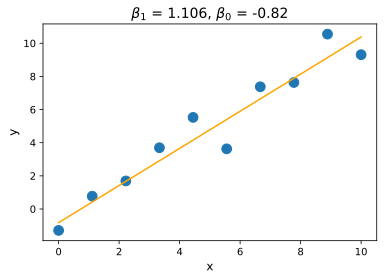

In [41]:
plt.scatter(df['x'], df['y'], s=95)
plt.plot(df['x'], df['x']*lm.coef_[0] + lm.intercept_, c='orange')
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.title(f"$\\beta_1$ = {beta1:.3f}, $\\beta_0$ = {lm.intercept_:.2f}", fontsize=14)
plt.savefig("/Users/parrt/Desktop/ols.svg")

### Adding an outlier

Let's add an outlier, making the last y value 100

In [42]:
y.iloc[-1] = 100
y

0     -1.292061
1      0.771459
2      1.693335
3      3.696459
4      5.526690
5      3.629886
6      7.373922
7      7.632434
8     10.550741
9    100.000000
Name: y, dtype: float64

In [43]:
X, y = df.drop('y',axis=1), df['y']
lm = LinearRegression()
lm.fit(X, y)
beta0 = lm.intercept_
beta1 = lm.coef_[0]
lm.score(X, y) # bounces around depending on test set

0.37730556218462163

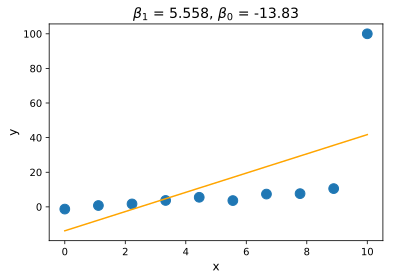

In [44]:
plt.scatter(X, y, s=95)
plt.plot(X, X*beta1 + lm.intercept_, c='orange')
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.title(f"$\\beta_1$ = {beta1:.3f}, $\\beta_0$ = {lm.intercept_:.2f}", fontsize=14)
plt.savefig("/Users/parrt/Desktop/outlier.svg")

The $\beta_1$ coefficient jumps from .99 to 5.35 and the Y intercept goes from 0.54 to -12.39. These are radically different coefficients that arise simply because one value is an outlier.

### L1 (Lasso) Regularization

If we constrain the $\beta_1$ coefficients strongly, then we can prevent the outlier from bending the regression line upwards.

R^2 training, test scores (0.157303696089602, -44.623386118302285)


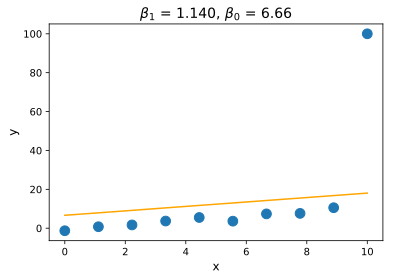

In [45]:
X, y = df.drop('y',axis=1), df['y']
y.iloc[-1] = 100
lm = Lasso(alpha=45)
lm.fit(X, y)
beta0 = lm.intercept_
beta1 = lm.coef_[0]
print("R^2 training, test scores", score(X, y, lm))

plt.scatter(X, y, s=95)
plt.plot(X, X*beta1 + lm.intercept_, c='orange')
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.title(f"$\\beta_1$ = {beta1:.3f}, $\\beta_0$ = {lm.intercept_:.2f}", fontsize=14)
plt.savefig("/Users/parrt/Desktop/lasso.svg")
plt.show()

The 0.11 score is not that great but we have sacrificed a bit of accuracy for a much more reasonable coefficient. The $\beta_1$ is now 0.93, very close to the 0.99 we get without the outlier.

What is wrong with the $y$-intercept?   There is a trade-off here between bias and generality. We have sacrificed accuracy a bit (line is above most of the points) but gained and generality because the trendline is right (we ignore the outlier).

## Ames housing data set

### Prep data set

Log into Kaggle and get [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data). A useful discussion on this data set is [here](https://nycdatascience.com/blog/student-works/machine-learning-project/).

In [46]:
df_ames = pd.read_csv("../../data/ames.csv")
df_ames.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [47]:
cols_with_missing = df_ames.columns[df_ames.isnull().any()]
cols = set(df_ames.columns) - set(cols_with_missing)

X = df_ames[cols]
X = X.drop('SalePrice', axis=1)
y = df_ames['SalePrice']
X.head()

,BldgType,LotConfig,LandSlope,3SsnPorch,EnclosedPorch,Fireplaces,LotShape,BsmtFinSF2,Heating,WoodDeckSF,...,LotArea,RoofMatl,LowQualFinSF,ExterQual,BedroomAbvGr,OpenPorchSF,SaleType,TotalBsmtSF,PavedDrive,MSSubClass
0,1Fam,Inside,Gtl,0,0,0,Reg,0,GasA,0,...,8450,CompShg,0,Gd,3,61,WD,856,Y,60
1,1Fam,FR2,Gtl,0,0,1,Reg,0,GasA,298,...,9600,CompShg,0,TA,3,0,WD,1262,Y,20
2,1Fam,Inside,Gtl,0,0,1,IR1,0,GasA,0,...,11250,CompShg,0,Gd,3,42,WD,920,Y,60
3,1Fam,Corner,Gtl,0,272,1,IR1,0,GasA,0,...,9550,CompShg,0,TA,3,35,WD,756,Y,70
4,1Fam,FR2,Gtl,0,0,1,IR1,0,GasA,192,...,14260,CompShg,0,Gd,4,84,WD,1145,Y,60


In [48]:
X = pd.get_dummies(X)
X.shape

(1460, 216)

###  Getting a baseline model

In [49]:
lm = LinearRegression()
score(X, y, lm, n=30)

(0.9253991359175693, -115695098.35854715)

In [50]:
coef = np.clip(lm.coef_,-1e10,1e8) #Clip so we can display

In [51]:
np.max(lm.coef_) #Wow, look at the size of this coefficient

9822066860023.123

In [52]:
np.std(lm.coef_)

1837184010067.015

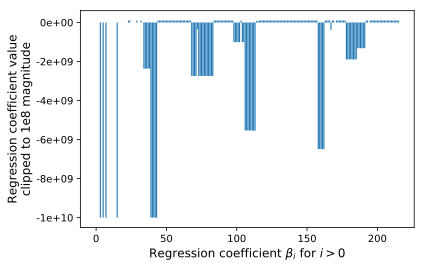

In [53]:
import matplotlib as mpl
plt.bar(range(len(coef)),coef)
plt.xlabel("Regression coefficient $\\beta_i$ for $i>0$", fontsize=12)
plt.ylabel("Regression coefficient value\nclipped to 1e8 magnitude", fontsize=12)
plt.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.1}'))
#plt.title(lm)
plt.show()

In [54]:
print("R^2 training, test scores", score(X, y, lm, n=30))

R^2 training, test scores (0.9242310059962175, -4067340.782377704)


Wow, look at the size of those coefficients. They are huge and all over the place, which is what we'd expect given such a terrible test R^2 score. The coefficients are so bad that prediction suffers.

## Normalization

We did not normalize our variable for the synthetic data set because we only had one variable.  Normally, we have to convert all X variables to standard scores so they are all in the same range and zero centered. If the variables are all in different ranges, regularization will squash some coefficients more than the others because all regularization does is constrain coefficients.

In [55]:
def normalize(X): # well, I'm creating standard variables here (u-x)/sigma
    for colname in X.columns:
        u = np.mean(X[colname])
        s = np.std(X[colname])
        X[colname] = (X[colname] - u) / s

In [56]:
normalize(X)

### L1 regularization with normalization

In [57]:
lm = Lasso(alpha=10, tol=0.1)
score(X, y, lm, n=10, random_state=42)

(0.9130380840904996, 0.8890891691967214)

In [58]:
print(f"std(coef)={np.std(lm.coef_):.1f}, num 0 coeff={len(np.where(lm.coef_<0.1)[0])}")

std(coef)=4509.2, num 0 coeff=102


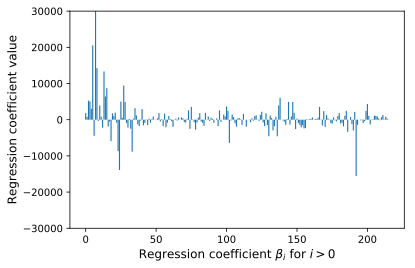

In [59]:
plt.bar(range(len(lm.coef_)),lm.coef_)
plt.xlabel("Regression coefficient $\\beta_i$ for $i>0$", fontsize=12)
plt.ylabel("Regression coefficient value", fontsize=12)
plt.ylim(-30_000, 30_000)
plt.show()

### L2 regularization with normalization

In [60]:
lm = Ridge(alpha=10)
score(X, y, lm, n=50)

(0.9240207232444283, 0.82560942846077)

In [61]:
print(f"std(coef)={np.std(lm.coef_):.1f}, num 0 coeff={len(np.where(lm.coef_<0.1)[0])}")

std(coef)=3275.0, num 0 coeff=102


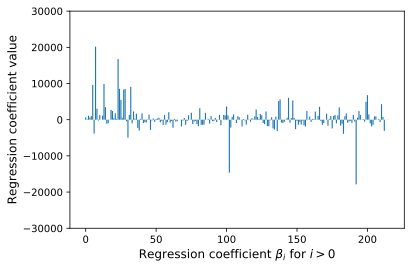

In [62]:
plt.bar(range(len(lm.coef_)),lm.coef_)
plt.xlabel("Regression coefficient $\\beta_i$ for $i>0$", fontsize=12)
plt.ylabel("Regression coefficient value", fontsize=12)
plt.ylim(-30_000, 30_000)
plt.show()